In [31]:
import gc
from copy import deepcopy
import numpy as np
import pandas as pd
from random import randint

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, TensorBoard
from keras import backend as K
from sklearn.model_selection import TimeSeriesSplit

from datetime import datetime
from keras.models import Model
from keras.models import load_model
from keras.optimizers import Adam, RMSprop
from keras.layers import Input, Conv2D, UpSampling2D, Dropout, LeakyReLU, BatchNormalization, Activation, Add, Subtract
from keras.layers.merge import Concatenate
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
# from keras.applications import VGG16
from keras import initializers
from keras import regularizers
from keras import backend as K

# from libs.pconv_model_UNet import PConvUnet
from keras.models import load_model  

from copy import deepcopy
from libs.util import random_mask

# Settings
MAX_BATCH_SIZE = 64

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
matrix_length = 32

matrix_df = pd.read_csv('./data/trafficV_M.csv', index_col=0, parse_dates=True)

In [33]:

def createTrainArray(week_history_num=0, minute_history_num=0):
    week_delta_list = [pd.Timedelta(i+1, unit='W') for i in range(week_history_num)]
    minute_delta_list = [pd.Timedelta((i+1)*15, unit='m') for i in range(minute_history_num)]
    # 参考历史数据时间点list
    delta_list = week_delta_list+minute_delta_list
    print(delta_list)
    
    set_up_time = pd.Timedelta(week_history_num, unit='W')
    # 根据历史数据选取多少，重新构建数据集
    # 相当于去除最开始week_history_num个周的数据，因为这些数据无法找到更前的数据
    train_df = matrix_df.truncate(before=matrix_df.index.min() + set_up_time)
    
    train_ago_array_tuple = tuple([np.array(matrix_df.loc[train_df.index - i]).reshape(-1, matrix_length, matrix_length, 1) for i in delta_list])
    train_df = np.array(train_df).reshape(-1, matrix_length, matrix_length, 1)
    # concatenate保持 待修复数据在前，参考历史数据在后。与random_mask函数生成mask相一致
    train_array = np.concatenate((train_df,)+train_ago_array_tuple, axis=3)
    print(train_array.shape)
    return train_array

In [34]:
week_history_num = 2
minute_history_num = 3

channel_num = week_history_num +minute_history_num +1
smooth_time = channel_num-1

train_array = createTrainArray(week_history_num, minute_history_num)
X_train, X_test = train_test_split(train_array, test_size = 0.1, shuffle=False)
# X_train, X_test = train_test_split(train_array, test_size = 0.1, random_state=42, shuffle=False)

# X_train = train_array[:16704-900-900]
# X_val = train_array[16704-900-900:16704-900]
# X_test = train_array[16704-900:]

[Timedelta('7 days 00:00:00'), Timedelta('14 days 00:00:00'), Timedelta('0 days 00:15:00'), Timedelta('0 days 00:30:00'), Timedelta('0 days 00:45:00')]
(16032, 32, 32, 6)


In [35]:
matrix_shape = (matrix_length, matrix_length, channel_num)
true_volume_shape = (matrix_length, matrix_length, 1)
history_volume_shape = (matrix_length, matrix_length, channel_num)

In [36]:
epoch_steps = X_train.shape[0] // MAX_BATCH_SIZE
val_steps = X_test.shape[0] // MAX_BATCH_SIZE
epoch_steps, val_steps

(225, 25)

In [37]:
# 以第一数据为例. 第一列为待预测数据
# 第一例：1.15 0:00  二：1.8 0:00  三：1.1 0:00  四：1.14 23:45  五：1.14 23:30  六：1.14 23:15
# X_train[0]

In [38]:
rand_size = 0.1
mask_type = 'rand'
block_size = (32, 32)

# 单个矩阵mask
rand_mask = random_mask(matrix_length, matrix_length, size=rand_size, channels=channel_num, smooth_time=smooth_time, type=mask_type, block_size=block_size)
# 堆叠成多个mask，方便对batch数据进行处理
mask = np.stack([rand_mask for _ in range(MAX_BATCH_SIZE)], axis=0)

In [39]:
import math
def l2(y_true, y_pred):
    size = 0
    if rand_size<=1:
        size = int((matrix_length * matrix_length) * rand_size)
    else:
        size = rand_size
        
    if size == 0:
        raise Exception("size == 0")
    return math.sqrt(np.sum(np.mean(np.square(y_true - y_pred), axis=0))/size)

def l1(y_true, y_pred):
    size = 0
    if rand_size<=1:
        size = int((matrix_length * matrix_length) * rand_size)
    else:
        size = rand_size
        
    if size == 0:
        raise Exception("size == 0")
    return np.sum(np.mean(np.abs(y_true - y_pred), axis=0))/size

def mape(y_true, y_pred):
    size = 0
    if rand_size<=1:
        size = int((matrix_length * matrix_length) * rand_size)
    else:
        size = rand_size
        
    if size == 0:
        raise Exception("size == 0")
        
    return np.sum(np.mean((np.abs(y_true - y_pred)/y_true)*100, axis=0))/size

In [40]:
# 加载数据
def load_data(volume_matrix, batch_size=MAX_BATCH_SIZE):
    n_batches=batch_size
    len_of_matrix = len(volume_matrix)

    batch_i = 0
    while ((batch_i+1)*batch_size < len_of_matrix):
        batch_matrix = volume_matrix[batch_i*batch_size: (batch_i+1)*batch_size]
        masked = deepcopy(batch_matrix)
        # true_volume为待修复数据， history_volume为历史数据及当前残差待修复数据
        true_volume = deepcopy(batch_matrix[:, :, :, :1])
        # mask==1代表有效采集点，0代表待预测采集点
        traffic_mean = masked[mask==1].mean()
        # 待预测点的值用已知值的平均值初始化
        masked[mask==0] = traffic_mean
        history_volume = deepcopy(masked)
        
        batch_i+=1

        yield true_volume, history_volume

In [41]:
def l2_loss(y_true, y_pred):
        """Calculate the L1 loss used in all loss calculations"""
        if K.ndim(y_true) == 4:
            return K.sum(K.square(y_pred - y_true), axis=[1,2,3])
        elif K.ndim(y_true) == 3:
            return K.sum(K.square(y_pred - y_true), axis=[1,2])
        else:
            raise NotImplementedError("Calculating L1 loss on 1D tensors? should not occur for this network")

# 缺失点mse
def loss_hole(y_true, y_pred):
    return l2_loss((1-mask) * y_true, (1-mask) * y_pred)

# 非缺失点mse
def loss_bg(y_true, y_pred):
    return l2_loss(mask * y_true, mask * y_pred)

def loss_fuc(y_true, y_pred):
    return loss_hole(y_true, y_pred)*3 + loss_bg(y_true, y_pred)

In [42]:
kernel_init = 'glorot_uniform'
bias_init = 'zeros'

# kernel_init = initializers.he_uniform()
# bias_init = initializers.he_uniform()
kernel_regul = regularizers.l2(1)
activity_regul = regularizers.l2(1)

learn_rate = 0.0002

# ResNet block
def identity_block(X, filters, f):

    F1, F2 = filters

    X_shortcut = X

    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = Conv2D(filters=F1, kernel_size=(f, f), strides=(1, 1), padding='same',
               kernel_initializer=kernel_init, bias_initializer=bias_init,
              kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(X)

    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same',
               kernel_initializer=kernel_init, bias_initializer=bias_init,
              kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(X)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

# ENCODER
def encoder_layer(img_in, filters, kernel_size, bn=True, resid=True):
    # conv = Conv2D(filters=filters, kernel_size=kernel_size, strides=(1, 1), padding='same')(img_in)
    conv = img_in
    if bn:
        conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
#             conv = MaxPooling2D((2, 2))(conv)


    if resid:
        conv = identity_block(conv, (filters, filters), kernel_size)

    return conv

# DECODER
def decoder_layer(img_in, e_conv, filters, kernel_size, bn=True, resid=True):
    # up_img = UpSampling2D(size=(2,2))(img_in)
    up_img = img_in
    concat_img = Concatenate(axis=3)([e_conv,up_img])
    conv = Conv2D(filters=filters, kernel_size=kernel_size, strides=(1, 1), padding='same',
                  kernel_initializer=kernel_init, bias_initializer=bias_init,
              kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(concat_img)
    if bn:
        conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0.1)(conv)

    if resid:
        conv = identity_block(conv, (filters, filters), kernel_size)
    return conv



def build_unet():      

    # INPUTS
    history_traffic_volume = Input(shape=history_volume_shape)

    # kernel_init = initializers.he_normal()
    # bias_init = initializers.he_normal()
    kernel_init = 'glorot_uniform'
    bias_init = 'zeros'

#         kernel_init = initializers.he_uniform()
#         bias_init = 'Orthogonal'
    kernel_regul = regularizers.l2(1)
    activity_regul = regularizers.l2(1)

    filters_base = 32
    e_conv1_head = Conv2D(filters=filters_base, kernel_size=3, strides=1, padding='same',
                          kernel_initializer=kernel_init, bias_initializer=bias_init,
                  kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(history_traffic_volume)
#         e_conv1_head = Conv2D(filters=filters_base*1, kernel_size=3, strides=1, padding='same',
#                               kernel_initializer=kernel_init, bias_initializer=bias_init,
#                       kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(e_conv1_head)
    e_conv1_tail = AveragePooling2D((2, 2))(e_conv1_head)
    e_conv1 = encoder_layer(e_conv1_tail, filters_base, 3, bn=False)

    e_conv2_head = Conv2D(filters=filters_base*2, kernel_size=3, strides=1, padding='same',
                          kernel_initializer=kernel_init, bias_initializer=bias_init,
                  kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(e_conv1)
    e_conv2_tail = AveragePooling2D((2, 2))(e_conv2_head)
    e_conv2 = encoder_layer(e_conv2_tail, filters_base*2, 3)

    e_conv3_head = Conv2D(filters=filters_base*4, kernel_size=3, strides=1, padding='same',
                          kernel_initializer=kernel_init, bias_initializer=bias_init,
                  kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(e_conv2)
    e_conv3_tail = AveragePooling2D((2, 2))(e_conv3_head)
    d_conv3_head = encoder_layer(e_conv3_tail, filters_base*4, 3)
    resid1 = Add()([e_conv3_tail, d_conv3_head])
    d_conv3_tail = UpSampling2D(size=(2, 2))(resid1)


    d_conv4_head = decoder_layer(d_conv3_tail, e_conv3_head, filters_base*2, 3)
    resid2 = Add()([d_conv4_head, e_conv2_tail])
    d_conv4_tail = UpSampling2D(size=(2, 2))(resid2)


    d_conv5_head = decoder_layer(d_conv4_tail, e_conv2_head, filters_base*1, 3)
    resid3 = Add()([d_conv5_head, e_conv1_tail])
    d_conv5_tail = UpSampling2D(size=(2, 2))(resid3)

    d_conv6_head = decoder_layer(d_conv5_tail, e_conv1_head, filters_base//2, 3, bn=False)


    outputs = Conv2D(1, 1, activation = 'relu', kernel_initializer=kernel_init, bias_initializer=bias_init,
                  kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(d_conv6_head)

    # Setup the model inputs / outputs
    model = Model(inputs=history_traffic_volume, outputs=outputs)

    # Compile the model RMSprop
    model.compile(
        optimizer = Adam(lr=learn_rate),
#         loss='mse'
        loss = loss_hole
    )

    return model

In [43]:
test_masked = deepcopy(X_test)
test_true_volume = deepcopy(X_test[:, :, :, :1])

test_length = len(X_test)
test_mask = np.stack([rand_mask for _ in range(test_length)], axis=0)

test_traffic_mean = X_test[test_mask==1].mean()
test_masked[test_mask==0] = test_traffic_mean
test_history_volume = deepcopy(test_masked)

In [44]:
lr_step = []
l2_validation = []

unet = build_unet()


def train(train_matrix, epochs, batch_size=MAX_BATCH_SIZE, learn_rate=0.01):

    min_mse = 999
    start_time = datetime.now()
    print("train start "+str(start_time))

    for epoch in range(epochs):
        if epoch>50 and epoch % 5 == 0 and epoch != 0:
            unet_lr = K.get_value(unet.optimizer.lr)
            if unet_lr>0.0001:
                K.set_value(unet.optimizer.lr, unet_lr*0.9)
                
        for batch_i, (true_volume, history_volume) in enumerate(load_data(train_matrix,batch_size)):
            # true_volume 真实待预测路网交通量  history_volume 路网交通量历史数据
            #  训练 unet
            #  训练 Generator
            g_loss = unet.train_on_batch(history_volume, true_volume)


        elapsed_time = datetime.now() - start_time
        # Plot the progress
        y_pred = unet.predict(test_history_volume)
        
        y_true = (1-test_mask[:,:,:,:1])*test_true_volume
        y_pred = (1-test_mask[:,:,:,:1])*y_pred
        l2_epoch_validation = l2(y_true, y_pred)
        
        if(l2_epoch_validation < min_mse and l2_epoch_validation<14):
            unet.save_weights('./model/dataRecorvey20191109/tmp/min_runet.h5')
            min_mse = l2_epoch_validation
        
        lr_step.append(K.get_value(unet.optimizer.lr))
        l2_validation.append(l2_epoch_validation)
        if epoch%1==0:
#             print("unet lr:"+ str(K.get_value(unet.optimizer.lr)))
            print ("[Epoch %d/%d]  [mse: %f] [G loss: %f] time: %s" % (epoch+1, epochs,
                                                                    l2_epoch_validation,
                                                                    g_loss,
                                                                    elapsed_time))

In [45]:
train(X_train, epochs=200, batch_size=MAX_BATCH_SIZE, learn_rate=learn_rate)

train start 2019-11-10 21:30:21.829244
[Epoch 1/200]  [mse: 45.377974] [G loss: 221615.015625] time: 0:00:44.114820
[Epoch 2/200]  [mse: 33.428470] [G loss: 112359.351562] time: 0:01:02.928030
[Epoch 3/200]  [mse: 26.621411] [G loss: 92186.062500] time: 0:01:20.931482
[Epoch 4/200]  [mse: 23.317435] [G loss: 71761.601562] time: 0:01:39.023174
[Epoch 5/200]  [mse: 21.559893] [G loss: 63374.523438] time: 0:01:57.192892
[Epoch 6/200]  [mse: 19.954969] [G loss: 57030.363281] time: 0:02:15.262983
[Epoch 7/200]  [mse: 18.976498] [G loss: 49729.386719] time: 0:02:33.763598
[Epoch 8/200]  [mse: 18.220698] [G loss: 60782.882812] time: 0:02:51.795451
[Epoch 9/200]  [mse: 18.371896] [G loss: 62692.902344] time: 0:03:10.366198
[Epoch 10/200]  [mse: 17.964484] [G loss: 73905.070312] time: 0:03:29.001473
[Epoch 11/200]  [mse: 15.907624] [G loss: 54804.949219] time: 0:03:47.326184
[Epoch 12/200]  [mse: 15.928813] [G loss: 61809.613281] time: 0:04:06.225487
[Epoch 13/200]  [mse: 15.780910] [G loss: 11

[Epoch 107/200]  [mse: 15.386695] [G loss: 14022.051758] time: 0:33:21.999945
[Epoch 108/200]  [mse: 18.276752] [G loss: 15373.256836] time: 0:33:40.763613
[Epoch 109/200]  [mse: 12.538694] [G loss: 18145.130859] time: 0:33:59.036959
[Epoch 110/200]  [mse: 16.949178] [G loss: 18990.117188] time: 0:34:17.205966
[Epoch 111/200]  [mse: 12.324806] [G loss: 11296.528320] time: 0:34:35.067759
[Epoch 112/200]  [mse: 12.416429] [G loss: 11014.887695] time: 0:34:52.926370
[Epoch 113/200]  [mse: 12.561467] [G loss: 10894.064453] time: 0:35:10.804865
[Epoch 114/200]  [mse: 12.645989] [G loss: 10758.326172] time: 0:35:28.635788
[Epoch 115/200]  [mse: 12.656398] [G loss: 10610.454102] time: 0:35:46.454956
[Epoch 116/200]  [mse: 13.290251] [G loss: 11715.132812] time: 0:36:04.283956
[Epoch 117/200]  [mse: 12.243451] [G loss: 10697.805664] time: 0:36:22.128591
[Epoch 118/200]  [mse: 12.511614] [G loss: 11109.493164] time: 0:36:40.013776
[Epoch 119/200]  [mse: 12.689445] [G loss: 10568.801758] time: 0

In [46]:
# unet.save_weights('./model/dataRecorvey20191109/runet_10_rmse11.97.h5')
# unet.load_weights('./model/RUnet/unet_60epoch_18rmse.h5')

In [47]:
# test_masked_tmp = deepcopy(X_test)
# test_true_volume_tmp = deepcopy(X_test[:, :, :, :1])

# test_length_tmp = len(X_test)
# rand_mask_tmp = random_mask(matrix_length, matrix_length, size=rand_size, channels=channel_num, smooth_time=smooth_time, type=mask_type, block_size=block_size)
# test_mask_tmp = np.stack([rand_mask_tmp for _ in range(test_length_tmp)], axis=0)

# test_traffic_mean_tmp = X_test[test_mask_tmp==1].mean()
# test_masked_tmp[test_mask_tmp==0] = test_traffic_mean_tmp
# test_history_volume_tmp = deepcopy(test_masked_tmp)


# y_pred = unet.predict(test_history_volume_tmp)

# # 仅对缺失数据进行l2评价。（对预测来说既对第一层进行评价，验证）
# y_true = (1-test_mask[:,:,:,:1])*test_true_volume_tmp
# y_pred = (1-test_mask[:,:,:,:1])*y_pred


y_pred = unet.predict(test_history_volume)

# 仅对缺失数据进行l2评价。（对预测来说既对第一层进行评价，验证）
y_true = (1-test_mask[:,:,:,:1])*test_true_volume
y_pred = (1-test_mask[:,:,:,:1])*y_pred

l2(y_true, y_pred), l1(y_true, y_pred)
# (13.612251463372885, 7.896321495663051)

(13.834843757656635, 9.044927773463078)

In [48]:
y_pred[y_true==0] += 1
y_true[y_true==0] += 1

mape(y_true, y_pred)
# 5.013244341615349

4.522821918543585

In [63]:
min_model = build_unet()
min_model.load_weights('./model/dataRecorvey20191109/tmp/min_runet.h5')

y_pred = min_model.predict(test_history_volume)

# 仅对缺失数据进行l2评价。（对预测来说既对第一层进行评价，验证）
y_true = (1-test_mask[:,:,:,:1])*test_true_volume
y_pred = (1-test_mask[:,:,:,:1])*y_pred

l2(y_true, y_pred), l1(y_true, y_pred)
# (11.085728026573435, 6.957813774885677)

(11.714141981641992, 7.708762648901143)

In [65]:
y_pred[y_true==0] += 1
y_true[y_true==0] += 1

mape(y_true, y_pred)
# 4.429743492502313

4.482528049269898

In [51]:
y_pred

array([[[[1.0000000e+00],
         [1.0000000e+00],
         [2.3937933e+02],
         ...,
         [1.0000000e+00],
         [2.6047516e+02],
         [1.0000000e+00]],

        [[1.0000000e+00],
         [1.0000000e+00],
         [1.0000000e+00],
         ...,
         [1.0000000e+00],
         [1.0000000e+00],
         [1.0000000e+00]],

        [[1.0000000e+00],
         [1.0000000e+00],
         [1.0000000e+00],
         ...,
         [1.0000000e+00],
         [1.0000000e+00],
         [1.0000000e+00]],

        ...,

        [[1.0000000e+00],
         [1.0000000e+00],
         [1.0000000e+00],
         ...,
         [1.0000000e+00],
         [1.5040254e+02],
         [1.5595634e+02]],

        [[1.0824694e+03],
         [1.2812312e+03],
         [1.0000000e+00],
         ...,
         [1.0000000e+00],
         [1.0000000e+00],
         [1.0000000e+00]],

        [[1.0000000e+00],
         [5.0897791e+02],
         [1.1435671e+03],
         ...,
         [1.0000000e+00],
        

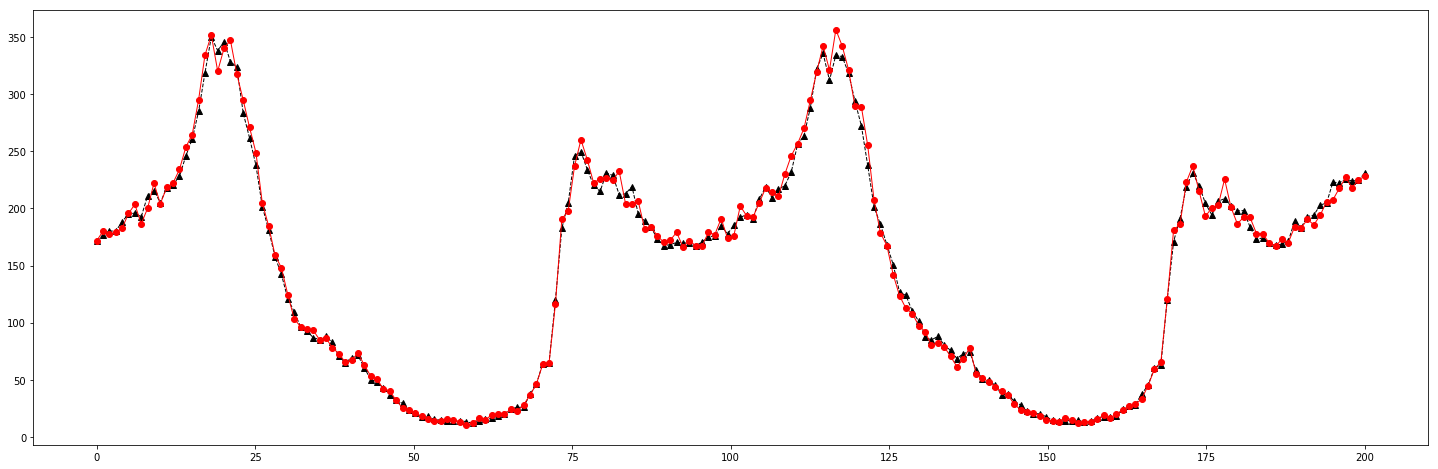

In [67]:
posX = 0
posY = 2
startX = 500
gapX = 200

y = test_true_volume[:, posX, posY, :][startX: startX+gapX]

yf = y_pred[:, posX, posY, :][startX: startX+gapX]

import matplotlib as mpl
import matplotlib.pyplot as plt


x = np.linspace(0, len(y), len(y))
fig, ax = plt.subplots(figsize=(25, 8))
lines = plt.plot(x, yf, 'k^--', x, y, 'ro-',linewidth=1, markersize=6)
plt.show()

In [53]:
y_pred

array([[[[1.0000000e+00],
         [1.0000000e+00],
         [2.3937933e+02],
         ...,
         [1.0000000e+00],
         [2.6047516e+02],
         [1.0000000e+00]],

        [[1.0000000e+00],
         [1.0000000e+00],
         [1.0000000e+00],
         ...,
         [1.0000000e+00],
         [1.0000000e+00],
         [1.0000000e+00]],

        [[1.0000000e+00],
         [1.0000000e+00],
         [1.0000000e+00],
         ...,
         [1.0000000e+00],
         [1.0000000e+00],
         [1.0000000e+00]],

        ...,

        [[1.0000000e+00],
         [1.0000000e+00],
         [1.0000000e+00],
         ...,
         [1.0000000e+00],
         [1.5040254e+02],
         [1.5595634e+02]],

        [[1.0824694e+03],
         [1.2812312e+03],
         [1.0000000e+00],
         ...,
         [1.0000000e+00],
         [1.0000000e+00],
         [1.0000000e+00]],

        [[1.0000000e+00],
         [5.0897791e+02],
         [1.1435671e+03],
         ...,
         [1.0000000e+00],
        

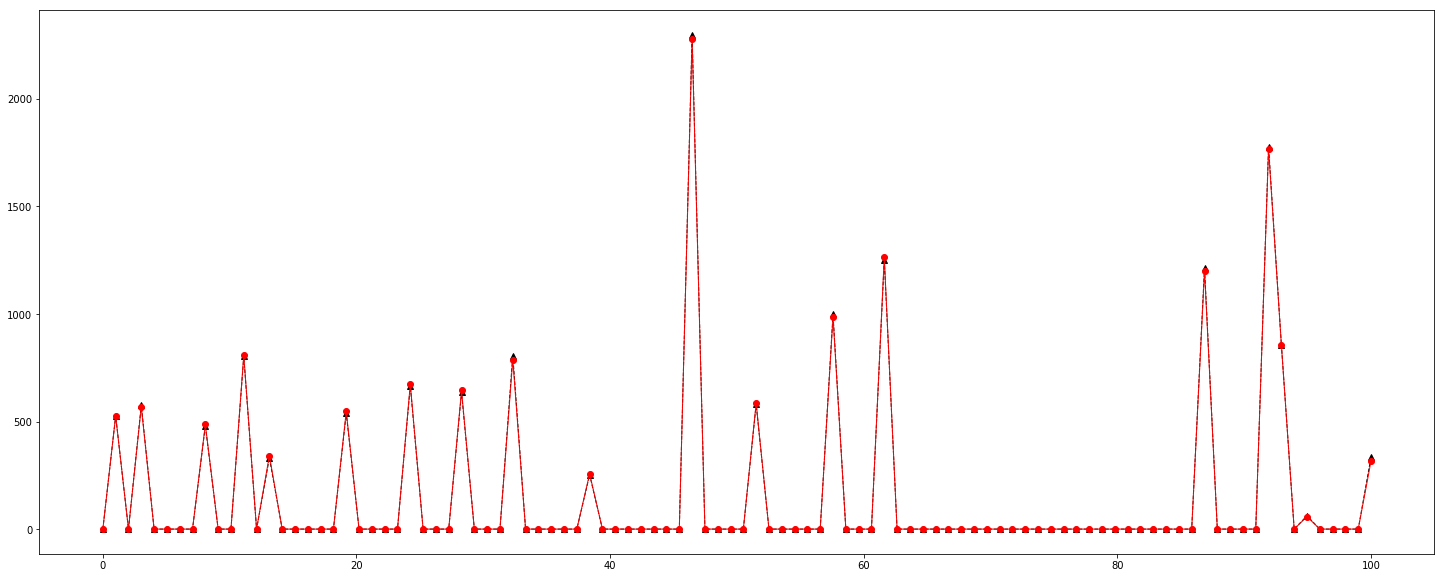

In [54]:
import matplotlib as mpl
import matplotlib.pyplot as plt

start_time = 1600
y = y_true.reshape(-1,)[start_time: start_time+100]
x = np.linspace(0, len(y), len(y))

yi = y_pred.reshape(-1,)[start_time: start_time+100]
xi = np.linspace(0, len(yi), len(yi))
fig, ax = plt.subplots(figsize=(25, 10))
# ax.plot(x, y, '.', linewidth=1, markersize=10)
lines = plt.plot(xi, yi, 'k^--', x, y, 'ro-',linewidth=1, markersize=6)
plt.show()

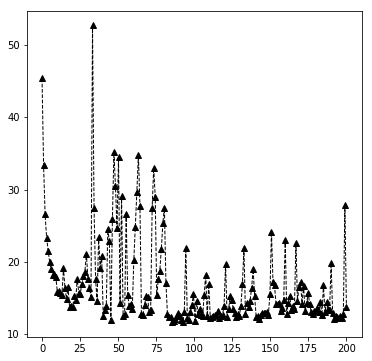

In [55]:
yi = l2_validation
xi = np.linspace(0, len(yi), len(yi))
fig, ax = plt.subplots(figsize=(6, 6))
lines = plt.plot(xi, yi, 'k^--', linewidth=1, markersize=6)
plt.show()

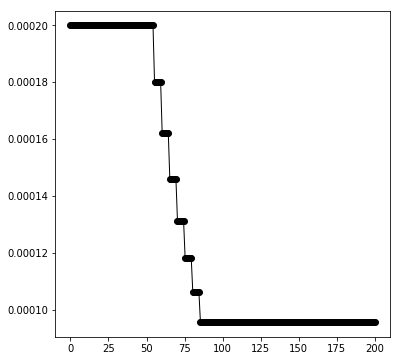

In [56]:
y = lr_step
x = np.linspace(0, len(y), len(y))
fig, ax = plt.subplots(figsize=(6, 6))
lines = plt.plot(x, y, 'ko-', linewidth=1, markersize=6)

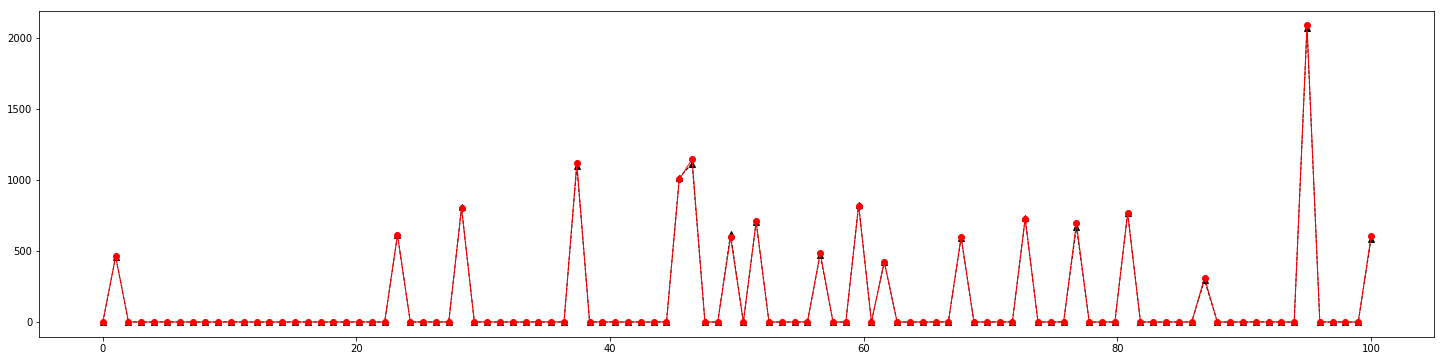

In [57]:
start_time = 3600
y = y_true.reshape(-1,)[start_time: start_time+100]
x = np.linspace(0, len(y), len(y))

yi = y_pred.reshape(-1,)[start_time: start_time+100]
xi = np.linspace(0, len(yi), len(yi))
fig, ax = plt.subplots(figsize=(25, 6))
# ax.plot(x, y, '.', linewidth=1, markersize=10)
lines = plt.plot(xi, yi, 'k^--', x, y, 'ro-',linewidth=1, markersize=6)
plt.show()

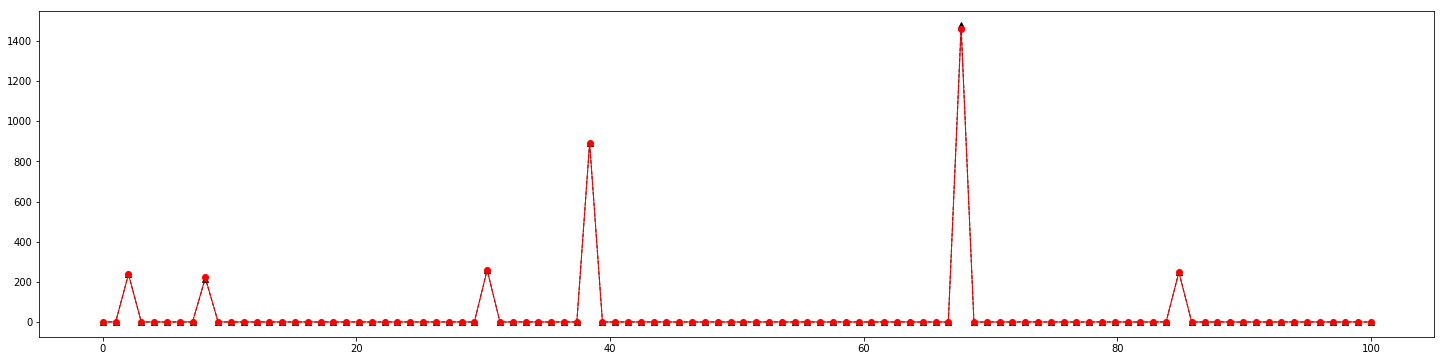

In [58]:
start_time = 0
y = y_true.reshape(-1,)[start_time: start_time+100]
x = np.linspace(0, len(y), len(y))

yi = y_pred.reshape(-1,)[start_time: start_time+100]
xi = np.linspace(0, len(yi), len(yi))
fig, ax = plt.subplots(figsize=(25, 6))
# ax.plot(x, y, '.', linewidth=1, markersize=10)
lines = plt.plot(xi, yi, 'k^--', x, y, 'ro-',linewidth=1, markersize=6)
plt.show()

In [59]:
y_pred

array([[[[1.0000000e+00],
         [1.0000000e+00],
         [2.3937933e+02],
         ...,
         [1.0000000e+00],
         [2.6047516e+02],
         [1.0000000e+00]],

        [[1.0000000e+00],
         [1.0000000e+00],
         [1.0000000e+00],
         ...,
         [1.0000000e+00],
         [1.0000000e+00],
         [1.0000000e+00]],

        [[1.0000000e+00],
         [1.0000000e+00],
         [1.0000000e+00],
         ...,
         [1.0000000e+00],
         [1.0000000e+00],
         [1.0000000e+00]],

        ...,

        [[1.0000000e+00],
         [1.0000000e+00],
         [1.0000000e+00],
         ...,
         [1.0000000e+00],
         [1.5040254e+02],
         [1.5595634e+02]],

        [[1.0824694e+03],
         [1.2812312e+03],
         [1.0000000e+00],
         ...,
         [1.0000000e+00],
         [1.0000000e+00],
         [1.0000000e+00]],

        [[1.0000000e+00],
         [5.0897791e+02],
         [1.1435671e+03],
         ...,
         [1.0000000e+00],
        

In [60]:
test_true_volume

array([[[[ 241.  ],
         [ 275.5 ],
         [ 237.5 ],
         ...,
         [ 381.  ],
         [ 258.5 ],
         [ 345.75]],

        [[ 138.5 ],
         [ 243.25],
         [ 239.5 ],
         ...,
         [ 159.  ],
         [ 199.5 ],
         [ 203.5 ]],

        [[1105.  ],
         [1222.  ],
         [1502.  ],
         ...,
         [ 563.25],
         [ 630.38],
         [ 276.88]],

        ...,

        [[ 614.5 ],
         [ 423.5 ],
         [ 447.  ],
         ...,
         [ 113.5 ],
         [ 151.  ],
         [ 156.5 ]],

        [[1108.  ],
         [1287.  ],
         [1023.25],
         ...,
         [ 132.  ],
         [ 151.  ],
         [ 156.5 ]],

        [[ 737.  ],
         [ 514.25],
         [1133.5 ],
         ...,
         [ 352.5 ],
         [ 118.5 ],
         [ 178.5 ]]],


       [[[ 279.5 ],
         [ 305.  ],
         [ 215.  ],
         ...,
         [ 414.5 ],
         [ 363.  ],
         [ 381.75]],

        [[ 179.  ],
         [ 2